This notebook provides an introduction to the basic concepts of machine learning.

Let's start by generating some data to work with.  Let's say that we have a dataset that has tested people on two continuous measures (processing speed and age) and one discrete measure (diagnosis with any psychiatric disorder).  First let's create the continuous data assuming that there is a relationship between these two variables.  We will make a function to generate a new dataset.

In [72]:
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats

def make_continuous_data(mean=[45,100],var=[10,10],cor=-0.6,N=100):
    """
    generate a synthetic data set with two variables
    """
    cor=numpy.array([[1.,cor],[cor,1.]])
    var=numpy.array([[var[0],0],[0,var[1]]])
    cov=var.dot(cor).dot(var)
    return numpy.random.multivariate_normal(mean,cov,N)

R-squared: 0.520948840226


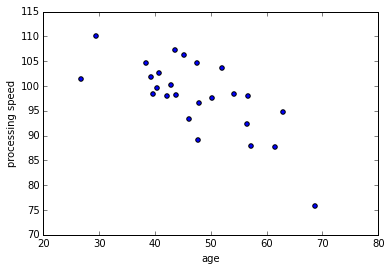

In [73]:
n=25
d=make_continuous_data(N=n)
plt.scatter(d[:,0],d[:,1])
plt.xlabel('age')
plt.ylabel('processing speed')
print 'R-squared:',numpy.corrcoef(d.T)[0,1]**2

What is the simplest story that we could tell about these data

In [74]:
mean=numpy.mean(d,0)
print mean

[ 47.23723133  97.91930036]


Is there a relation between processing speed and age? Compute the linear regression equation to find out. 

In [75]:
slope,intercept,r,p,se=scipy.stats.linregress(d[:,0],d[:,1])

processing speed = 123.364153 + -0.538661*age
p = 4.6509718436e-05
rsquared= 0.520948840226


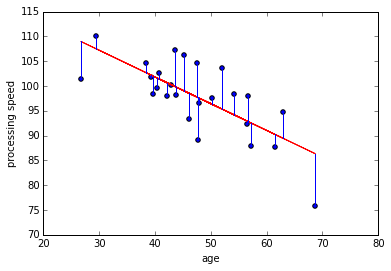

In [76]:
print 'processing speed = %f + %f*age'%(intercept,slope)
print 'p =',p

def get_RMSE(y,pred):
    return numpy.sqrt(numpy.mean((y - pred)**2))

def get_R2(y,pred):
    """ compute r-squared"""
    return numpy.corrcoef(y,pred)[0,1]**2

ax=plt.scatter(d[:,0],d[:,1])
plt.xlabel('age')
plt.ylabel('processing speed')
plt.plot(d[:,0], slope * d[:,0] + intercept, color='red')
# plot residual lines
d_predicted=slope*d[:,0] + intercept
for i in range(d.shape[0]):
    x=d[i,0]
    y=d[i,1]
    plt.plot([x,x],[d_predicted[i],y],color='blue')

RMSE=get_RMSE(d[:,1],d_predicted)
rsq=get_R2(d[:,1],d_predicted)
print 'rsquared=',rsq

This shows us that linear regression can provide a simple description of a complex dataset - we can describe the entire dataset in 2 numbers. Now let's ask how good this description is for a new dataset generated by the same process:


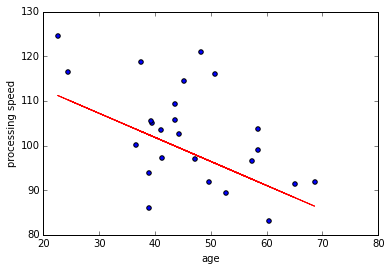

In [77]:
d_new=make_continuous_data(N=n)
d_new_predicted=intercept + slope*d[:,0]
RMSE_new=get_RMSE(d_new[:,1],d_new_predicted)

ax=plt.scatter(d_new[:,0],d_new[:,1])
plt.xlabel('age')
plt.ylabel('processing speed')
plt.plot(d_new[:,0], slope * d_new[:,0] + intercept, color='red')


Now let's do this 100 times and look at how variable the fits are.

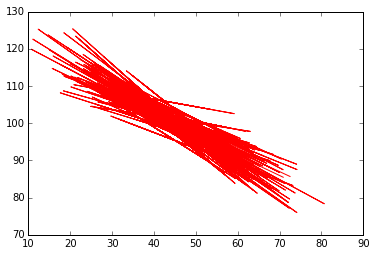

In [78]:
nruns=100
slopes=numpy.zeros(nruns)
intercepts=numpy.zeros(nruns)
rsquared=numpy.zeros(nruns)

fig = plt.figure()
ax = fig.gca()

for i in range(nruns):
    data=make_continuous_data(N=n)
    slopes[i],intercepts[i],_,_,_=scipy.stats.linregress(data[:,0],data[:,1])
    ax.plot(data[:,0], slopes[i] * data[:,0] + intercepts[i], color='red')
    rsquared[i]=numpy.corrcoef(data[:,1],intercept + slope*data[:,0])[0,1]**2


In [79]:
print 'Original R2:',rsq
print 'Mean R2 for new datasets on original model:',numpy.mean(rsquared)


Original R2: 0.520948840226
Mean R2 for new datasets on original model: 0.362682559328


Now let's see if we can get a more reasonable estimate of our accuracy at predicting on a new sample, using cross-validation.

In [80]:
import sklearn.cross_validation
loo=sklearn.cross_validation.LeaveOneOut(n)

slopes_loo=numpy.zeros(n)
intercepts_loo=numpy.zeros(n)
pred=numpy.zeros(n)

data=make_continuous_data(N=n)
ctr=0
for train,test in loo:
    slopes_loo[ctr],intercepts_loo[ctr],_,_,_=scipy.stats.linregress(data[train,0],data[train,1])
    pred[ctr]=intercepts_loo[ctr] + slopes_loo[ctr]*data[test,0]
    ctr+=1

print 'R2 for leave-one-out prediction:',numpy.corrcoef(pred,data[:,1])[0,1]**2

R2 for leave-one-out prediction: 0.204519739169


Now let's look at the effect of outliers on correlation and prediction.


R2 for regression with outlier: 0.772660622691


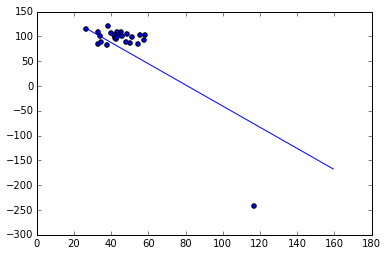

In [81]:
# add an outlier
data_null=make_continuous_data(N=n,cor=0.0)
outlier_multiplier=2.0

data=numpy.vstack((data_null,[numpy.max(data_null[:,0])*outlier_multiplier,
                         numpy.max(data_null[:,1])*outlier_multiplier*-1]))
plt.scatter(data[:,0],data[:,1])
slope,intercept,r,p,se=scipy.stats.linregress(data[:,0],data[:,1])
plt.plot([numpy.min(data[:,0]),intercept + slope*numpy.min(data[:,0])],
         [numpy.max(data[:,0]),intercept + slope*numpy.max(data[:,0])])
rsq_outlier=r**2
print 'R2 for regression with outlier:',rsq_outlier

In [82]:
loo=sklearn.cross_validation.LeaveOneOut(data.shape[0])

pred_outlier=numpy.zeros(data.shape[0])

ctr=0
for train,test in loo:
    s,i,_,_,_=scipy.stats.linregress(data[train,0],data[train,1])
    pred_outlier[ctr]=i + s*data[test,0]
    ctr+=1

print 'R2 for leave-one-out prediction:',numpy.corrcoef(pred_outlier,data[:,1])[0,1]**2

R2 for leave-one-out prediction: 0.0161159006975


Now let's look at model complexity.  

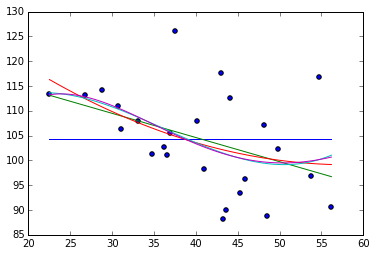

In [99]:
data=make_continuous_data(N=n)
loo=sklearn.cross_validation.LeaveOneOut(n)


npolyorders=5
# fit models of increasing complexity
plt.scatter(data[:,0],data[:,1])
xp=numpy.linspace(numpy.min(data[:,0]),numpy.max(data[:,0]),100)

for i in range(npolyorders):
    f = numpy.polyfit(data[:,0], data[:,1], i)
    p=numpy.poly1d(f)
    plt.plot(xp,p(xp))
    
# compute in-sample and out-of-sample error using LOO
pred=numpy.zeros((n,npolyorders))
mean_trainerr=numpy.zeros(npolyorders)
prederr=numpy.zeros(npolyorders)

for i in range(npolyorders):
    ctr=0
    trainerr=numpy.zeros(n)
    for train,test in loo:
        f = numpy.polyfit(data[train,0], data[train,1], i)
        p=numpy.poly1d(f)
        trainerr[ctr]=numpy.sqrt(numpy.mean((data[train,1]-p(data[train,0]))**2))
        pred[test,i]=p(data[test,0])
        ctr+=1
    mean_trainerr[i]=numpy.mean(trainerr)
    prederr[i]=numpy.sqrt(numpy.mean((data[:,1]-pred[:,i])**2))
    

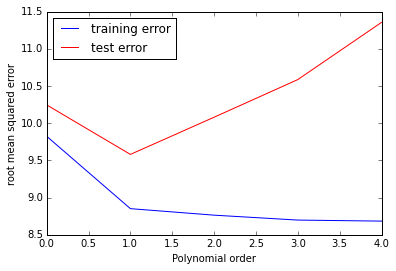

In [104]:
plt.plot(range(npolyorders),mean_trainerr)
plt.plot(range(npolyorders),prederr,color='red')
plt.xlabel('Polynomial order')
plt.ylabel('root mean squared error')
plt.legend(['training error','test error'],loc=2)

In [102]:
?plt.legend
